 <div class="alert alert-info" role="alert">
 <p class ="lead"> 
 <h1>Tarea 3 </h1>
 <h2>Física Computacional</h2>
 </div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/1f/Julia_Programming_Language_Logo.svg/1200px-Julia_Programming_Language_Logo.svg.png" style="height:42px;display:inline">


> Autor: Celeste Castro Granados $\mathbb C \hat{e}l \mathbb s$

Primero llamaremos a las bibliotecas que vamos a necesitar:

In [1]:
using Plots
using LaTeXStrings

# 1. En clase vimos el método de Euler mejorado en el que nosotros introducimos el Jacobiano de forma analítica para ser evaluado por el método de integración. Realice una función que implemente el mismo método de integración, pero en lugar de calcular el Jacobiano con una función que lo evalúa analíticamente, ahora sea calculado de manera numérica utilizando la derivación numérica.


En general, una ecuación diferencial se representa por:

$$ \frac{d\vec x}{dt} = \vec g (\vec x, t) $$

Y sabemos por lo visto en clase que el método de Euler mejorado realiza una aproximación mediante la derivada del sistema de ecuaciones utilizando la matriz jacobiana y el desarrollo de Taylor de la $\vec x (t)$ por medio de la implementación del siguiente algoritmo: 

$$ \vec x_{n+1} = \vec x_n + \delta \vec g ( \vec x_n , t_n ) + \frac{1}{2} \delta^2 \mathbb{J}^* ( \vec x_n, t_n) \cdot \vec g^* ( \vec x_n, t_n ) $$

En donde: $\mathbb{J}^* = \big ( \mathbb{J}, \frac{\partial \vec g}{\partial t} \big )$ con $\mathbb{J}$ el Jacobiano, y $\vec g^* = (\vec g, 1)$. (se agrega un 1 como entrada extra en $g^*$ para que no haya problemas al momento de multiplicar por $\mathbb{J}^*$, i.e. que las dimensiones concuerden)

Ahora, queremos una función que calcule de manera numérica la matriz $\mathbb{J}^*$. Para esto, recordamos que:

$$\mathbb{J}^* =
\begin{bmatrix}
  \frac{\partial g_1}{\partial x_1} & 
    \frac{\partial g_1}{\partial x_2} & 
    ... &
    \frac{\partial g_1}{\partial x_n} &
    \frac{\partial g_1}{\partial t} \\
  \frac{\partial g_2}{\partial x_1} & 
    \frac{\partial g_2}{\partial x_2} & 
    ... &
    \frac{\partial g_2}{\partial x_n} &
    \frac{\partial g_2}{\partial t} \\
    . & & & \\
    . & & & \\
    . & & & \\
  \frac{\partial g_n}{\partial x_1} & 
    \frac{\partial g_n}{\partial x_2} & 
    ... &
    \frac{\partial g_n}{\partial x_n} & 
    \frac{\partial g_n}{\partial t} 
\end{bmatrix}$$

Por tanto, necesitamos calcular las derivadas parciales de la función $\vec g$. Dichas parciales las calcularemos mediante la siguiente expresión:

$$ \partial_{x_j} g_{i,n} = \bigg (\frac{1}{2h} \bigg ) \bigg  [ g_i \big (( x_{1,n}, ..., x_{n,n}, t_n ) + (0,...,h,...,0) \big ) - g_i \big (( x_{1,n}, ..., x_{n,n}, t_n ) - (0,...,h,...,0) \big ) \bigg] $$


En donde, $h$ se encuentra en la j-ésima posición ya que estamos calculando la parcial respecto a $x_j$. 

A continuación, procedemos a programar la función que nos de esta matriz:

In [2]:
function jacobiano_t(xi,h,f,t)
    #xi-consiste en las variables del problema, donde calcularemos las parciales
    #h-paso utilizado para obtener las derivadas parciales
    #f-función a la cual sacaremos el jacobiano
    #t-tiempo
    
    #Definimos la matriz que vamos a ir llenando:
    jacob=zeros(length(f(xi,t)),length(xi)+1)
    
    for i in 1:length(f(xi,t)), j in 1:length(xi) #ciclo para ir llenando las entradas de la matriz
        #xp1,xp2-vectores que tienen un aumento o disminución en la i-ésima entrda.
        xp1=zeros(length(xi))
        xp2=zeros(length(xi))
        
        for k in 1:length(xi) #ciclo con el cual definiremos las entradas de los vectores donde evaluaremos la función para obtener la derivada parcial
            if  k==j #incremento a la j-ésima entrada del vector
                xp1[k]=xi[j]+h
                xp2[k]=xi[j]-h
            else
                xp1[k]=xi[j]
                xp2[k]=xi[j]
            end
        end
        
        jacob[i,j]=(f(xp1,t)[i]-f(xp2,t)[i])/(xp1[j]-xp2[j]) #entrada ij de la matriz, sin tomar en cuenta la entrada de la parcial temporal
        jacob[i,length(xi)+1]=(f(xi,t+h)[i]-f(xi,t-h)[i])/(2h) #componentes de la columna de la parcial temporal
    end
    return jacob
end

jacobiano_t (generic function with 1 method)

Luego, como ya definimos la función que calcula de manera numérica la matriz $\mathbb{J}^*$, modificamos el algoritmo de Euler mejorado que hace uso del jacobiano con dependencia temporal visto en clase para integrarle nuestra función:

In [3]:
function Euler_mejorado_Jacobnum(edo,edo1,p_ini,t)
    #edo-función de la ecuacion diferencial
    #edo1-función de la ecuacion diferencial con un elemento 1 en la última entrada
    #p_ini-condiciones iniciales de la posición
    #t-tiempo
    # J y g con dependencia temporal.
    sol = zeros(length(t),length(p_ini))
    sol[1,:] = p_ini
    δ = t[2]-t[1]
    for i in 1:(length(t)-1)
        eval_edo = edo(sol[i,:],t[i])
        g=edo1(sol[i,:],t[i]) #función por la que multiplicaremos el jacobiano
        if length(eval_edo) == length(p_ini)
            sol[i+1,:] .= sol[i,:] .+ δ .*eval_edo
        else
            sol[i+1,:] .= sol[i,:] .+ δ .*eval_edo[1:(end-1)]
        end
        sol[i+1,:] .+= 0.5*(δ^2) .*(jacobiano_t(sol[i,:],δ,edo,t[i]) *g )
    end
    return sol
end

Euler_mejorado_Jacobnum (generic function with 1 method)

# 2. Utilizando los integradores de Euler mejorado con Jacobiano analítico, Euler mejorado con Jacobiano numérico, Runge-Kutta de $2^°$ orden y Runge-Kutta de $4^°$ orden, encuentre un paso de integración que proporcione una precisión de $10^{-4}$ en la solución para la siguiente ecuación:

## $$\dddot{y} + \ddot{y}^2 - 3\dot{y}^3 + cos^2 y = e^{-t} sin (3t)$$

## Con condiciones iniciales $\ddot{y}(1)=1$, $\dot{y}(1)=2$, $y(1)=1$. En particular que sucede en el intervalo $t \in [1,2]$ y $t \in [1,2.1]$. 


Recordamos primero los algoritmos vistos en clase de los métodos que utilizaremos:

### Euler mejorado con Jacobiano analítico

In [4]:
function Euler_mejorado_J_t_p(edo,p_ini,t,jacob)
    # J y g con dependencia temporal
    sol = zeros(length(t),length(p_ini))
    sol[1,:] = p_ini
    δ = t[2]-t[1]
    for i in 1:(length(t)-1)
        eval_edo = edo(sol[i,:],t[i])
        if length(eval_edo) == length(p_ini)
            sol[i+1,:] .= sol[i,:] .+ δ .*eval_edo
        else
            sol[i+1,:] .= sol[i,:] .+ δ .*eval_edo[1:(end-1)]
        end
        sol[i+1,:] .+= 0.5*(δ^2) .*(jacob(sol[i,:],t[i]) *eval_edo )
    end
    return sol
end

Euler_mejorado_J_t_p (generic function with 1 method)

### Runge-Kutta de $2^°$ orden

In [5]:
function RK_2(edo,x_ini,t)
    sol = zeros( length(t) , length(x_ini) )
    sol[1,:] .= x_ini
    δ = t[2]-t[1]
    for i in 1:length(t)-1
        k1 = sol[i,:] .+ 0.5*δ .*edo(sol[i,:],t[i])
        sol[i+1,:] .= sol[i,:] .+ δ*edo(k1,t[i]+0.5*δ)
    end
    return sol
end

RK_2 (generic function with 1 method)

### Runge-Kutta de $4^°$ orden

In [6]:
function RK_4(edo,x_ini,t)
    sol = zeros( length(t) , length(x_ini) )
    sol[1,:] .= x_ini
    δ = t[2]-t[1]
    for i in 1:length(t)-1
        k1 = edo(sol[i,:],t[i])
        k2 = edo(sol[i,:] .+ 0.5*δ.*k1 , t[i] + 0.5*δ)
        k3 = edo(sol[i,:] .+ 0.5*δ.*k2 , t[i] + 0.5*δ)
        k4 = edo(sol[i,:] .+ δ.*k2 , t[i] + δ)
        sol[i+1,:] .= sol[i,:] .+ (δ/6.0).*(k1 .+ 2.0.*k2 .+ 2.0.*k3 .+ k4)
    end
    return sol
end

RK_4 (generic function with 1 method)

### Euler mejorado con Jacobiano numérico 

En este caso, utilizaremos el algoritmo desarrollado en el problema 1.

### Definición de EDO y Jacobiano analítico

Vamos a analizar ahora la ecuación que tenemos: 

Para facilitar las cosas, podemos ver a $y$ como la posición:

$$ \Rightarrow \dot{y}= v \quad  (\text{velocidad}) $$
$$ \Rightarrow \ddot{y}=\dot{v}= a \quad (\text{aceleración}) $$

Por lo que, la ecuación diferencial se transforma en:

$$ \dot{a} + a^2 -3v^3 + cos^2 y = e^{-t} sin(3t) $$

Y tenemos las siguientes 3 EDO's de 1er orden:

$$ \dot{a} = e^{-t} sin(3t) - a^2 +3v^3 - cos^2 y  $$
$$ \dot{v} = a $$
$$ \dot{y} = v $$

Y utilizando las condiciones iniciales dadas sabemos que: 
$a(1) =1$ , $v(1)=2$, $y(1)=1$. 

Por lo tanto, podemos definir las funciones g's como:

$$ g_1 = e^{-t} sin(3t) - a^2 +3v^3 - cos^2 y  $$
$$ g_2 = a $$
$$ g_3 = v $$

Luego, calculamos de manera analítica el Jacobiano: 

$$\mathbb{J}^* =
\begin{bmatrix}
  \frac{\partial g_1}{\partial a} & 
    \frac{\partial g_1}{\partial v} & 
    \frac{\partial g_1}{\partial y} &
    \frac{\partial g_1}{\partial t} \\
  \frac{\partial g_2}{\partial a} & 
    \frac{\partial g_2}{\partial v} &
    \frac{\partial g_2}{\partial y} & 
    \frac{\partial g_2}{\partial t} \\
  \frac{\partial g_3}{\partial a} & 
    \frac{\partial g_3}{\partial v} &
    \frac{\partial g_3}{\partial y} & 
    \frac{\partial g_3}{\partial t} 
\end{bmatrix}$$

$$ \Rightarrow \mathbb{J}^* =
\begin{bmatrix}
  -2a & 9v^2 & -2 sin(y) cos(y) & e^{-t} (2 cos (3t) -sin (3t)) \\
  1 & 0 & 0 & 0 \\
  0 & 1 & 0 & 0 
\end{bmatrix}$$


Por lo tanto, ya tenemos todo listo. A continuación, procedemos a programar la ecuación diferencial y el Jacobiano:

In [7]:
function edo_y_1(variables,t) 
    #variables=(a,v,y)
    g1=(exp(-t)*sin(3*t))-(variables[1]^2)+3*(variables[2]^3)-((cos(variables[3]))^2)
    g2=variables[1]
    g3=variables[2]
    return [g1,g2,g3,1] #Se agrega un 1 para que las dimensiones coincidan y se pueda multiplicar por el jacobiano
end

edo_y_1 (generic function with 1 method)

In [8]:
function jacob_edo_y(variables,t)
    Jacob = zeros(3,4) #definimos una matriz de ceros de 3x4 para poder llenarla
    Jacob[1,1] = -2*variables[1]
    Jacob[1,2] = 9*variables[2]^2
    Jacob[1,3] = -2*sin(variables[3])*cos(variables[3])
    Jacob[1,4] = exp(-t)*(2*cos(3*t)-sin(3*t))
    Jacob[2,1] = 1
    Jacob[3,2] = 1
    return Jacob
end

jacob_edo_y (generic function with 1 method)

Y recordamos que también debemos definir la función de la ecuación diferencial sin el 1 extra en el arreglo que entrega como resultado:

In [9]:
function edo_y(variables,t) 
    #variables=(a,v,y)
    g1=(exp(-t)*sin(3*t))-(variables[1]^2)+3*(variables[2]^3)-((cos(variables[3]))^2)
    g2=variables[1]
    g3=variables[2]
    return [g1,g2,g3]
end

edo_y (generic function with 1 method)

Finalmente, definimos las condiciones iniciales para poder utilizarlas al momento de calcular las soluciones con cada uno de los métodos:

In [10]:
cond_inic_y=[1,2,1]; #condiciones iniciales

A continuación, vamos a obtener las soluciones con cada uno de los métodos mencionados arriba, encontrando en cada caso el paso adecuado para el cual obtenemos una precisión de $10^{-4}$, i.e. que obtenemos al menos 4 cifras significativas:

**Euler con Jacobiano analítico**

Vamos a ver que sucede primero en el intervalo [1,1.8]:

In [11]:
t_euler_a1= collect(1:0.001:1.8)
solucion_euler_a1 = Euler_mejorado_J_t_p(edo_y_1,cond_inic_y,t_euler_a1,jacob_edo_y)

801×3 Array{Float64,2}:
   1.0       2.0      1.0    
   1.02275   2.00101  1.002  
   1.0455    2.00205  1.004  
   1.06823   2.0031   1.006  
   1.09096   2.00418  1.00801
   1.11368   2.00528  1.01001
   1.13639   2.00641  1.01202
   1.15908   2.00756  1.01403
   1.18177   2.00873  1.01603
   1.20445   2.00992  1.01804
   1.22712   2.01114  1.02005
   1.24977   2.01237  1.02207
   1.27242   2.01364  1.02408
   ⋮                         
 382.429    37.0242   6.99894
 388.496    37.4096   7.03616
 394.693    37.8012   7.07376
 401.022    38.199    7.11176
 407.487    38.6032   7.15016
 414.091    39.014    7.18897
 420.839    39.4314   7.22819
 427.735    39.8557   7.26783
 434.782    40.2869   7.3079 
 441.985    40.7252   7.3484 
 449.348    41.1709   7.38935
 456.875    41.6239   7.43075

Notamos que en el intervalo [1,1.8], las soluciones se encuentran bien definidas, sin embargo, veremos que si nos movemos a  los intervalos [1,1.9], [1,2] ó [1,2.1] las soluciones ya no se encontrarán bien definidas:

In [12]:
t_euler_a2= collect(1:0.001:2.1)
solucion_euler_a2= Euler_mejorado_J_t_p(edo_y_1,cond_inic_y,t_euler_a2,jacob_edo_y)

1101×3 Array{Float64,2}:
   1.0        2.0        1.0    
   1.02275    2.00101    1.002  
   1.0455     2.00205    1.004  
   1.06823    2.0031     1.006  
   1.09096    2.00418    1.00801
   1.11368    2.00528    1.01001
   1.13639    2.00641    1.01202
   1.15908    2.00756    1.01403
   1.18177    2.00873    1.01603
   1.20445    2.00992    1.01804
   1.22712    2.01114    1.02005
   1.24977    2.01237    1.02207
   1.27242    2.01364    1.02408
   ⋮                            
 NaN        NaN        NaN      
 NaN        NaN        NaN      
 NaN        NaN        NaN      
 NaN        NaN        NaN      
 NaN        NaN        NaN      
 NaN        NaN        NaN      
 NaN        NaN        NaN      
 NaN        NaN        NaN      
 NaN        NaN        NaN      
 NaN        NaN        NaN      
 NaN        NaN        NaN      
 NaN        NaN        NaN      

**Euler con Jacobiano numérico**

Nuevamente veamos primero que sucede en el intervalo [1,1.8]:

In [13]:
t_euler_n1 = collect(1:0.001:1.8)
solucion_euler_n1= Euler_mejorado_Jacobnum(edo_y,edo_y_1,cond_inic_y,t_euler_n1)

801×3 Array{Float64,2}:
   1.0       2.0      1.0    
   1.02276   2.00101  1.002  
   1.0455    2.00205  1.004  
   1.06824   2.0031   1.006  
   1.09097   2.00418  1.00801
   1.11369   2.00528  1.01001
   1.1364    2.00641  1.01202
   1.15909   2.00756  1.01403
   1.18178   2.00873  1.01603
   1.20446   2.00992  1.01804
   1.22713   2.01114  1.02005
   1.24979   2.01237  1.02207
   1.27244   2.01364  1.02408
   ⋮                         
 382.449    37.0254   6.99906
 388.516    37.4109   7.03627
 394.713    37.8025   7.07388
 401.042    38.2003   7.11188
 407.508    38.6046   7.15028
 414.113    39.0153   7.18909
 420.861    39.4328   7.22831
 427.757    39.857    7.26795
 434.805    40.2883   7.30803
 442.008    40.7267   7.34853
 449.372    41.1723   7.38948
 456.899    41.6254   7.43088

Y ahora para el intervalo [1,2.1]:

In [14]:
t_euler_n2= collect(1:0.001:2.1)
solucion_euler_n2= Euler_mejorado_Jacobnum(edo_y,edo_y_1,cond_inic_y,t_euler_n2)

1101×3 Array{Float64,2}:
   1.0        2.0        1.0    
   1.02276    2.00101    1.002  
   1.0455     2.00205    1.004  
   1.06824    2.0031     1.006  
   1.09097    2.00418    1.00801
   1.11369    2.00528    1.01001
   1.1364     2.00641    1.01202
   1.15909    2.00756    1.01403
   1.18178    2.00873    1.01603
   1.20446    2.00992    1.01804
   1.22713    2.01114    1.02005
   1.24979    2.01237    1.02207
   1.27244    2.01364    1.02408
   ⋮                            
 NaN        NaN        NaN      
 NaN        NaN        NaN      
 NaN        NaN        NaN      
 NaN        NaN        NaN      
 NaN        NaN        NaN      
 NaN        NaN        NaN      
 NaN        NaN        NaN      
 NaN        NaN        NaN      
 NaN        NaN        NaN      
 NaN        NaN        NaN      
 NaN        NaN        NaN      
 NaN        NaN        NaN      

**Runge-Kutta de orden 2**

Primero para el intervalo [1,1.8]:

In [15]:
tRK2_1 = collect(1:0.001:1.8)
solucion_RK2_1 = RK_2(edo_y,cond_inic_y,tRK2_1)

801×3 Array{Float64,2}:
   1.0       2.0      1.0    
   1.02276   2.00101  1.002  
   1.0455    2.00205  1.004  
   1.06824   2.0031   1.006  
   1.09097   2.00418  1.00801
   1.11369   2.00528  1.01001
   1.13639   2.00641  1.01202
   1.15909   2.00756  1.01403
   1.18178   2.00873  1.01603
   1.20446   2.00992  1.01804
   1.22713   2.01114  1.02005
   1.24979   2.01237  1.02207
   1.27244   2.01364  1.02408
   ⋮                         
 382.462    37.0259   6.99908
 388.53     37.4113   7.03629
 394.727    37.8029   7.0739 
 401.057    38.2008   7.1119 
 407.522    38.605    7.1503 
 414.128    39.0158   7.18911
 420.877    39.4333   7.22833
 427.774    39.8576   7.26798
 434.822    40.2888   7.30805
 442.026    40.7272   7.34855
 449.39     41.1729   7.3895 
 456.918    41.626    7.4309 

Y ahora para el intervalo [1,2.1]:

In [16]:
tRK2_2 = collect(1:0.001:2.1)
solucion_RK2_2= RK_2(edo_y,cond_inic_y,tRK2_2)

DomainError: DomainError with -Inf:
cos(x) is only defined for finite x.

**Runge-Kutta de orden 4**

Primero para el intervalo [1,1.8]:

In [18]:
tRK4_1 = collect(1:0.001:1.8)
solucion_RK4_1 = RK_4(edo_y,cond_inic_y,tRK4_1)

801×3 Array{Float64,2}:
   1.0       2.0      1.0    
   1.02276   2.00101  1.002  
   1.0455    2.00205  1.004  
   1.06824   2.0031   1.006  
   1.09097   2.00418  1.00801
   1.11369   2.00528  1.01001
   1.1364    2.00641  1.01202
   1.15909   2.00756  1.01403
   1.18178   2.00873  1.01603
   1.20446   2.00992  1.01804
   1.22713   2.01114  1.02005
   1.24979   2.01237  1.02207
   1.27244   2.01364  1.02408
   ⋮                         
 382.497    37.0286   6.9993 
 388.566    37.4141   7.03652
 394.765    37.8058   7.07413
 401.095    38.2037   7.11213
 407.562    38.608    7.15054
 414.169    39.0189   7.18935
 420.919    39.4364   7.22858
 427.817    39.8608   7.26822
 434.866    40.2921   7.3083 
 442.071    40.7306   7.34881
 449.436    41.1763   7.38976
 456.966    41.6295   7.43117

Y ahora para el intervalo [1,2.1]:

In [19]:
tRK4_2 = collect(1:0.001:2.1)
solucion_RK4_2 = RK_4(edo_y,cond_inic_y,tRK4_2)

DomainError: DomainError with -Inf:
cos(x) is only defined for finite x.

En todas las soluciones que obtuvimos, observamos que todos los métodos tienen problemas a partir de aproximadamente 1.8, ya que ahí, se presentan indeterminaciones. 

Finalmente, vamos a graficar la solución con el método de Rugen-Kutta de orden 4 y con el método de Euler con Jacobiano numérico para poder visualizar su comportamiento cerca de la zona de indeterminación que detectamos arriba, así como también, para comprobar que el algoritmo desarrollado en el problema 1 funciona correctamente:

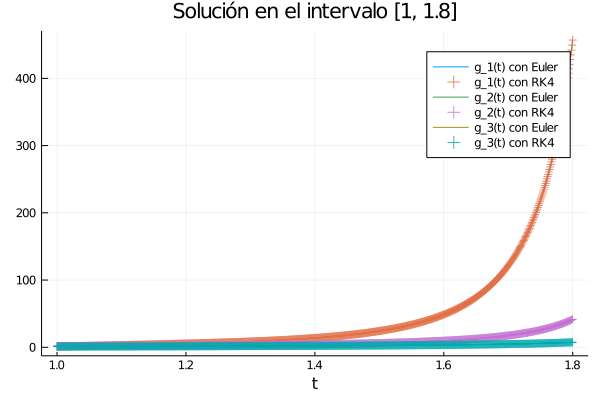

In [20]:
plot(title="Solución en el intervalo [1, 1.8]",xlabel="t") 
plot!(t_euler_n1,solucion_euler_n1[:,1],label="g_1(t) con Euler")
scatter!(tRK4_1,solucion_RK4_1[:,1],m=:cross,label="g_1(t) con RK4")
plot!(t_euler_n1,solucion_euler_n1[:,2],label="g_2(t) con Euler")
scatter!(tRK4_1,solucion_RK4_1[:,2],m=:cross,label="g_2(t) con RK4")
plot!(t_euler_n1,solucion_euler_n1[:,3],label="g_3(t) con Euler")
scatter!(tRK4_1,solucion_RK4_1[:,3],m=:cross,label="g_3(t) con RK4")

Primero, notamos que las soluciones con ambos métodos son similares, por lo que, podemos concluir que el algoritmo del problema 1 trabaja adecuadamente. Por otra parte, observando la gráfica vemos que efectivamente tenemos una variable que diverge y por tanto, no podemos obtener una solución acertada en dicha zona con ninguno de los métodos. De hecho, para asegurarnos aún más, podemos tomar nuestro intervalo de tiempo como la unión de dos intervalos, en donde el segundo intervalo va a ir desde 1.7 hasta 2.1 pero con muchos más puntos que en el primer intervalo para tratar de visualizar mejor el comportamiento justo en la zona donde habíamos visto que tenemos problemas:

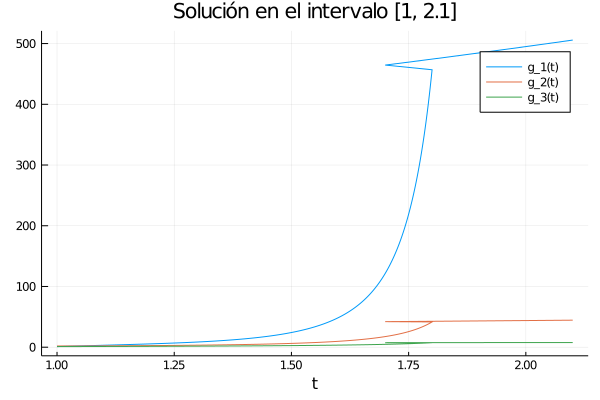

In [21]:
t_euler_n21 = collect(1.7:0.08:2.1) # t entre 1.7 y 2.1
time=vcat(t_euler_n1,t_euler_n21)
solucion_analitico_21 = Euler_mejorado_J_t_p(edo_y_1,cond_inic_y,time,jacob_edo_y)
#solucion_numerico_21=Euler_mejorado_Jacobnum(edo_y,edo_y_1,cond_inic_y,time)
plot(title="Solución en el intervalo [1, 2.1]",xlabel="t") 
plot!(time,solucion_analitico_21[:,1],label="g_1(t)")
plot!(time,solucion_analitico_21[:,2],label="g_2(t)")
plot!(time,solucion_analitico_21[:,3],label="g_3(t)")

Efectivamente hay problemas a partir de 1.75 aprox, y de hecho ni siquiera logra graficarlo bien.

# 3. Modifique las funciones integradoras que programamos en clase (Euler mejorado, Runge-Kutta de $2^°$ orden y Runge-Kutta de $4^°$ orden) para que se puedan pasar argumentos opcionales al sistema de ecuaciones diferenciales de tal manera que se puedan modificar parámetros al momento de hacer la integración. Una vez hecho esto, obtenga la solución de la siguiente ecuación diferencial:

## $$ \ddot{x} + \frac{1}{10} \dot{x} + 4 sin x = \frac{1}{2} sin (\omega t) $$

## Con condiciones iniciales $\dot{x}(0) = 1$ y $x(0) = 0$ y para $\omega = {1, 1.1, 1.2, 1.3, ..., 2.9, 3}$. Realice la gráfica de algunas soluciones que representen el comportamiento de la solución en función de $\omega$ y explique su resultado. La solución debe tener una precisión de por lo menos $10^{−5}$. 


### Euler mejorado

In [22]:
function Euler_mejorado_J_t_p_omega(edo,p_ini,t,jacob,ω) 
    #anexamos omega, que va a ser el parámetro que vamos a poder modificar
    # J y g con dependencia temporal
    sol = zeros(length(t),length(p_ini))
    sol[1,:] = p_ini
    δ = t[2]-t[1]
    for i in 1:(length(t)-1)
        eval_edo = edo(sol[i,:],t[i],ω) #Añadimos ω porque ahora la edo depende de ella
        if length(eval_edo) == length(p_ini)
            sol[i+1,:] .= sol[i,:] .+ δ .*eval_edo
        else
            sol[i+1,:] .= sol[i,:] .+ δ .*eval_edo[1:(end-1)]
        end
        sol[i+1,:] .+= 0.5*(δ^2) .*(jacob(sol[i,:],t[i],ω) *eval_edo )
    end
    return sol
end

Euler_mejorado_J_t_p_omega (generic function with 1 method)

### Runge-Kutta de $2^°$ orden

In [23]:
function RK_2_omega(edo,x_ini,t,ω)
    #anexamos ω, que va a ser el parámetro que vamos a poder modificar
    sol = zeros( length(t) , length(x_ini) )
    sol[1,:] .= x_ini
    δ = t[2]-t[1]
    for i in 1:length(t)-1
        k1 = sol[i,:] .+ 0.5*δ .*edo(sol[i,:],t[i],ω)
        sol[i+1,:] .= sol[i,:] .+ δ*edo(k1,t[i]+0.5*δ,ω)
    end
    return sol
end

RK_2_omega (generic function with 1 method)

### Runge-Kutta de $4^°$ orden

In [24]:
function RK_4_omega(edo,x_ini,t,ω)
    #anexamos ω, que va a ser el parámetro que vamos a poder modificar
    sol = zeros( length(t) , length(x_ini) )
    sol[1,:] .= x_ini
    δ = t[2]-t[1]
    for i in 1:length(t)-1
        k1 = edo(sol[i,:],t[i],ω)
        k2 = edo(sol[i,:] .+ 0.5*δ.*k1 , t[i] + 0.5*δ,ω)
        k3 = edo(sol[i,:] .+ 0.5*δ.*k2 , t[i] + 0.5*δ,ω)
        k4 = edo(sol[i,:] .+ δ.*k2 , t[i] + δ,ω)
        sol[i+1,:] .= sol[i,:] .+ (δ/6.0).*(k1 .+ 2.0.*k2 .+ 2.0.*k3 .+ k4)
    end
    return sol
end

RK_4_omega (generic function with 1 method)

### EDO y Jacobiano

Vamos a analizar ahora la ecuación diferencial que tenemos:

Tenemos:

$$ \ddot{x} + \frac{1}{10} \dot{x} + 4 sin x = \frac{1}{2} sin (\omega t) $$

Con condiciones iniciales $\dot{x}(0) = 1$ y $x(0) = 0$ y para $\omega = {1, 1.1, 1.2, 1.3, ..., 2.9, 3}$.

Siguiendo el análisi realizado en la ecuación del problema 2, podemos ver a $x$ como la posición:

$$ \Rightarrow \dot{x}= v \quad  (\text{velocidad}) $$
$$ \Rightarrow \ddot{x}=\dot{v} \quad (\text{aceleración}) $$

Por lo que, la ecuación diferencial se transforma en:

$$ \dot{v} + \frac{1}{10} v + 4 sin (x) = \frac{1}{2} sin (\omega t) $$

Y tenemos las siguientes 2 EDO's de 1er orden:

$$ \dot{v} = \frac{1}{2} sin (\omega t) - \frac{1}{10} v - 4 sin (x)  $$
$$ \dot{x} = v $$

Y utilizando las condiciones iniciales dadas sabemos que: $v(0)=1$, $x(0)=0$

Por lo tanto, podemos definir las funciones g's como:

$$ g_1=\frac{1}{2} sin (\omega t) - \frac{1}{10} v - 4 sin (x)  $$
$$ g_2 = v $$

A continuación, procedemos a programar la ecuación diferencial:

In [25]:
function edo_x(variables,t,ω) 
    #variables=(v,x)
    g1=(0.5*sin(ω*t))-((1/10)*variables[1]) - (4*sin(variables[2]))
    g2=variables[1]
    return [g1,g2,1]
end

edo_x (generic function with 1 method)

Definimos las condiciones iniciales y el intervalo de tiempo que ocuparemos:

In [26]:
cond_inic_x=[1,0]
tiempo=collect(0:0.1:10*π);

Y calculamos su Jacobiano de manera analítica:

$$\mathbb{J}^* =
\begin{bmatrix}
    \frac{\partial g_1}{\partial v} & 
    \frac{\partial g_1}{\partial x} &
    \frac{\partial g_1}{\partial t} \\ 
    \frac{\partial g_2}{\partial v} &
    \frac{\partial g_2}{\partial x} & 
    \frac{\partial g_2}{\partial t} \\
\end{bmatrix}$$

$$ \Rightarrow \mathbb{J}^* =
\begin{bmatrix}
  -\frac{1}{10} & -4 cos(x) & \frac{1}{2}\omega cos(\omega t) \\
  1 & 0 & 0
\end{bmatrix}$$

A continuación, procedemos a programar este Jacobiano:

In [27]:
function jacob_edo_x(variables,t,ω)
    Jacob = zeros(2,3) #definimos una matriz de ceros de 2x3 para poder llenarla
    Jacob[1,1] = -1/10
    Jacob[1,2] = -4*cos(variables[2])
    Jacob[1,3] = 0.5*ω*cos(ω*t)
    Jacob[2,1] = 1
    return Jacob
end

jacob_edo_x (generic function with 1 method)

Y por último, recordamos que para los métodos de Runge-Kutta debemos volver a definir la EDO pero sin agregarle el 1 extra al arreglo que regresa la función.

In [28]:
function edo_x_RK(variables,t,ω) 
    #variables=(v,x)
    g1=(0.5*sin(ω*t))-((1/10)*variables[1]) - (4*sin(variables[2]))
    g2=variables[1]
    return [g1,g2]
end

edo_x_RK (generic function with 1 method)

Con esto, ya tenemos todo lo necesario para obtener la solución con los 3 métodos. Ahora, el valor de $\omega$ no influye en la obtención de las cifras significativas ya que se trata de un parámetro constante, por tanto, basta con ver que se obtienen las 5 cifras significativas para una ω en particular. Vamos a obtener las soluciones para $\omega=1.1$:

In [29]:
solucion_euler_ω = Euler_mejorado_J_t_p_omega(edo_x,cond_inic_x,tiempo,jacob_edo_x,1.1) #solucion con el metodo de Euler

315×2 Array{Float64,2}:
  1.0        0.0       
  0.9728     0.0995    
  0.91242    0.194581  
  0.822022   0.282046  
  0.706003   0.359081  
  0.569575   0.423364  
  0.41836    0.473127  
  0.258067   0.507173  
  0.0942823  0.524877  
 -0.0676317  0.526163  
 -0.222571   0.511479  
 -0.365698   0.481772  
 -0.492474   0.438457  
  ⋮                    
 -0.174011   0.103502  
 -0.164017   0.0864759 
 -0.149969   0.0706764 
 -0.132995   0.0564559 
 -0.114295   0.0440488 
 -0.0950871  0.0335673 
 -0.0765538  0.025002  
 -0.0597875  0.0182288 
 -0.0457431  0.0130197 
 -0.0351973  0.00905929
 -0.0287157  0.0059642 
 -0.0266302  0.00330564

In [30]:
solucion_RK2_ω = RK_2_omega(edo_x_RK,cond_inic_x,tiempo,1.1) #solucion con el metodo de Runge-Kutta de orden 2

315×2 Array{Float64,2}:
  1.0        0.0       
  0.972807   0.0995    
  0.912472   0.194582  
  0.822141   0.282051  
  0.706189   0.359098  
  0.569806   0.4234    
  0.418599   0.473185  
  0.258272   0.507254  
  0.0944166  0.524977  
 -0.0675923  0.526274  
 -0.222634   0.511593  
 -0.365855   0.481877  
 -0.492704   0.438545  
  ⋮                    
 -0.174312   0.103369  
 -0.164325   0.0863153 
 -0.150271   0.0704883 
 -0.133276   0.0562415 
 -0.11454    0.0438107 
 -0.0952822  0.0333096 
 -0.0766867  0.0247301 
 -0.0598476  0.0179491 
 -0.0457222  0.0127396 
 -0.03509    0.00878687
 -0.0285196  0.00570791
 -0.0263462  0.00307398

In [31]:
solucion_RK4_ω = RK_4_omega(edo_x_RK,cond_inic_x,tiempo,1.1) #solucion con el metodo de Runge-Kutta de orden 4

315×2 Array{Float64,2}:
  1.0         0.0       
  0.972938    0.0989269 
  0.913185    0.193488  
  0.823816    0.280556  
  0.709094    0.357377  
  0.574084    0.421663  
  0.424269    0.47166   
  0.265241    0.506166  
  0.1025      0.524538  
 -0.0586631   0.526672  
 -0.213199    0.51298   
 -0.356324    0.484368  
 -0.483551    0.442204  
  ⋮                     
 -0.210295    0.133614  
 -0.211206    0.112486  
 -0.206171    0.091571  
 -0.195953    0.0714265 
 -0.181485    0.0525254 
 -0.163819    0.0352409 
 -0.144083    0.0198365 
 -0.123428    0.00646139
 -0.102974   -0.00484909
 -0.0837655  -0.0141683 
 -0.0667243  -0.0216682 
 -0.0526135  -0.0276054 

Observamos que para los 3 métodos se cumple que se tienen cinco cifras significativas como minímo. Por lo tanto, procedemos ahora sí a realizar las gráficas para presentar las soluciones con distintas ω:

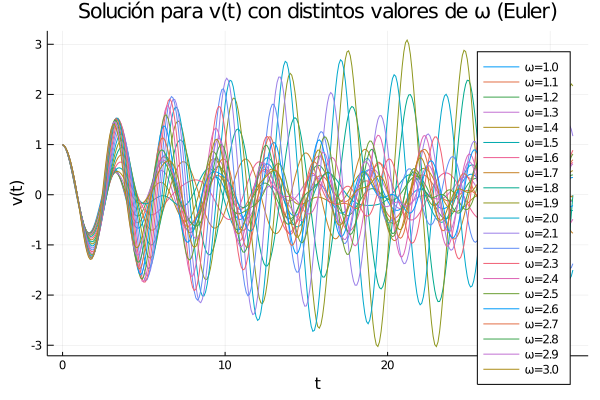

In [32]:
ωs=collect(1:0.1:3)
plot(title="Solución para v(t) con distintos valores de ω (Euler)",xlabel="t",ylabel="v(t)")
for ω_i in ωs
    solucion = Euler_mejorado_J_t_p_omega(edo_x,cond_inic_x,tiempo,jacob_edo_x,ω_i)
    plot!(tiempo,solucion[:,1],label ="ω=$(ω_i)", lw=1.0)
end
plot!()

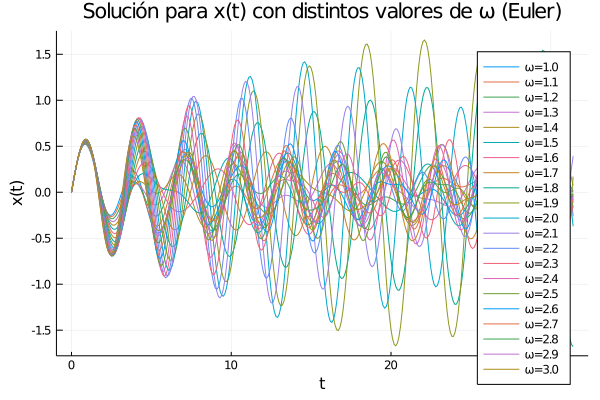

In [33]:
plot(title="Solución para x(t) con distintos valores de ω (Euler)",xlabel="t",ylabel="x(t)")
for ω_i in ωs
    solucion = Euler_mejorado_J_t_p_omega(edo_x,cond_inic_x,tiempo,jacob_edo_x,ω_i)
    plot!(tiempo,solucion[:,2],label ="ω=$(ω_i)", lw=1.0)
end
plot!()

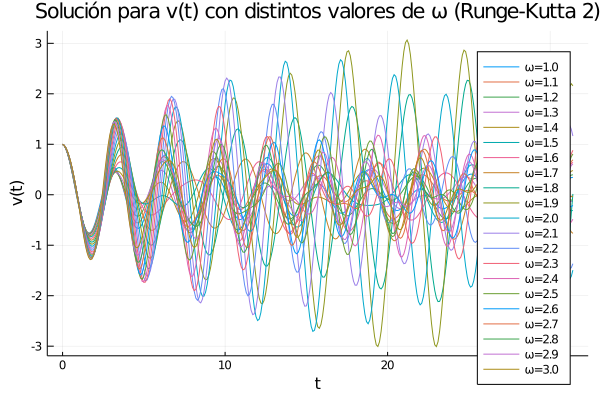

In [34]:
plot(title="Solución para v(t) con distintos valores de ω (Runge-Kutta 2)",xlabel="t",ylabel="v(t)")
for ω_i in ωs
    solucion = RK_2_omega(edo_x_RK,cond_inic_x,tiempo,ω_i)
    plot!(tiempo,solucion[:,1],label ="ω=$(ω_i)", lw=1.0)
end
plot!()

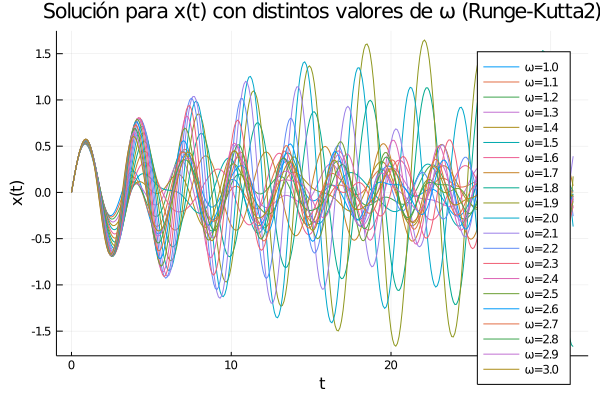

In [35]:
plot(title="Solución para x(t) con distintos valores de ω (Runge-Kutta2)",xlabel="t",ylabel="x(t)")
for ω_i in ωs
    solucion = RK_2_omega(edo_x_RK,cond_inic_x,tiempo,ω_i)
    plot!(tiempo,solucion[:,2],label ="ω=$(ω_i)", lw=1.0)
end
plot!()

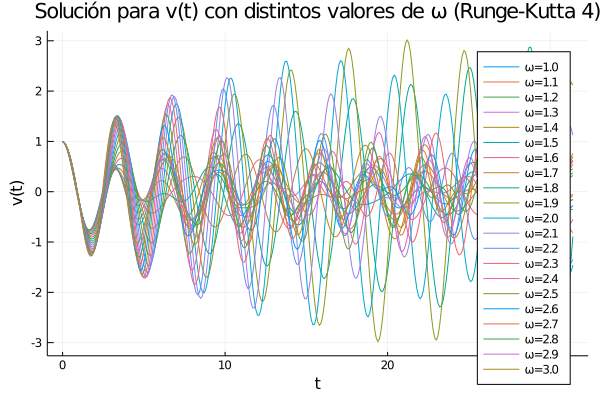

In [36]:
plot(title="Solución para v(t) con distintos valores de ω (Runge-Kutta 4)",xlabel="t",ylabel="v(t)")
for ω_i in ωs
    solucion = RK_4_omega(edo_x_RK,cond_inic_x,tiempo,ω_i)
    plot!(tiempo,solucion[:,1],label ="ω=$(ω_i)", lw=1.0)
end
plot!()

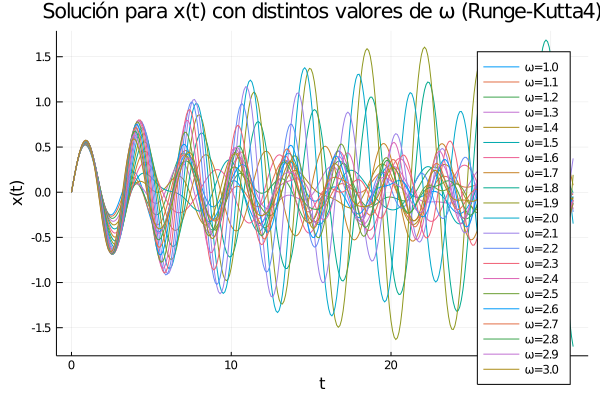

In [37]:
plot(title="Solución para x(t) con distintos valores de ω (Runge-Kutta4)",xlabel="t",ylabel="x(t)")
for ω_i in ωs
    solucion = RK_4_omega(edo_x_RK,cond_inic_x,tiempo,ω_i)
    plot!(tiempo,solucion[:,2],label ="ω=$(ω_i)", lw=1.0)
end
plot!()

Podemos notar que tanto para $x(t)$, como $v(t)$, tenemos un fenómeno de resonancia. Asimismo, conforme el sistema va avanzando en el tiempo, la amplitud de las soluciones va creciendo, haciendo que mientras mayor sea el valor de $\omega$ también sea mayor el valor de la amplitud.

# 4. Considere el siguiente sistema de ecuaciones diferenciales:

### $$ \frac{dx}{dt} = 10 (y-x) $$

### $$ \frac{dy}{dt} = x (28-z)-y $$

### $$ \frac{dz}{dt} = xy - \frac{8}{3} z $$

# Realice una integración numérica del sistema de ecuaciones con el método de Runge-Kutta de $4^°$ y realice los siguientes ejercicios:

## a) Elija una condición inicial aleatoria en el $x, y, z \in [−5, 5]$ y realice la gráfica de la solución en el plano xy, xz y yz y comente sus observaciones.

## b) Ahora tome 3 soluciones parecidas. Para ello proponga 3 condiciones iniciales tales que en la coordenada en $y$ las condiciones iniciales difieran entre si en $10^{−2}$. Explique lo que observa.

### Nota: De preferencia realice integraciones con tiempos relativamente largos en los que pueda apreciar diferencias en el comportamiento de las soluciones. Además asegure que cada una de las soluciones que encuentre sea convergente en por lo menos 5 cifras ($10^{−5}$), es decir encuentre un paso adecuado para realizar la integración.

Vamos a definir primero nuestro sistema de ecuaciones:

In [38]:
function edo_xyz(variables,t)
    #variables(x,y,z)
    dx=10*(variables[2]-variables[1])
    dy=variables[1]*(28-variables[3])-variables[2]
    dz=variables[1]*variables[2]-((8/3)*variables[3])
    return[dx,dy,dz]
end

edo_xyz (generic function with 1 method)

#### a) Utilizaremos la función `rand` para elegir una condición inicial aleatoria: 



In [39]:
cond_inic_xyz=[-5rand(),5rand(),5rand()];

**Gráficas de la solución:**

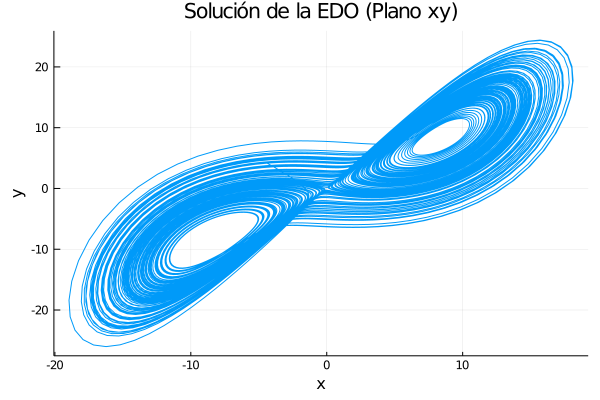

In [43]:
plot(title="Solución de la EDO (Plano xy)",xlabel="x",ylabel="y")
tiempo = collect(0:0.01:50π)
sol_num_rk4 = RK_4(edo_xyz,cond_inic_xyz,tiempo)
plot!(sol_num_rk4[:,1],sol_num_rk4[:,2])
plot!(legend=false)

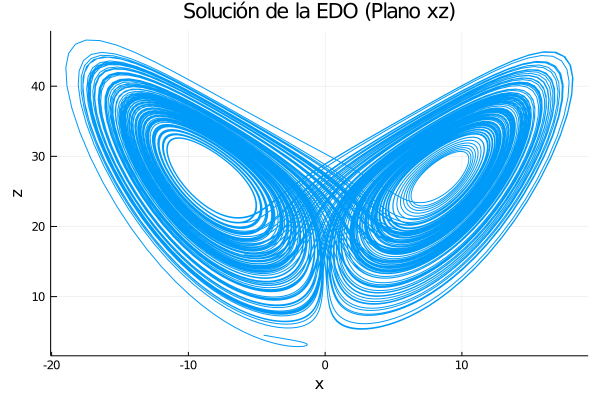

In [44]:
plot(title="Solución de la EDO (Plano xz)",xlabel="x",ylabel="z")
tiempo = collect(0:0.01:50π)
sol_num_rk4 = RK_4(edo_xyz,cond_inic_xyz,tiempo)
plot!(sol_num_rk4[:,1],sol_num_rk4[:,3])
plot!(legend=false)

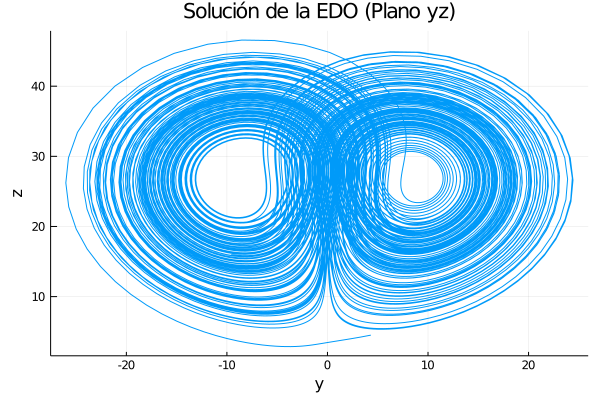

In [45]:
plot(title="Solución de la EDO (Plano yz)",xlabel="y",ylabel="z")
tiempo = collect(0:0.01:50π)
sol_num_rk4 = RK_4(edo_xyz,cond_inic_xyz,tiempo)
plot!(sol_num_rk4[:,2],sol_num_rk4[:,3])
plot!(legend=false)

En las 3 gráficas obtenemos la misma forma pero vista desde distintos ángulos. Asimismo, podemos ver que conforme el tiempo va creciendo, aparecen más líneas que siguen la misma trayectoria.

Finalmente, vamos a comprobar que la solución tiene al menos 5 cifras significativas:

In [46]:
sol_num_rk4 = RK_4(edo_xyz,cond_inic_xyz,tiempo)

15708×3 Array{Float64,2}:
 -4.50125   4.31199    4.5062 
 -3.7123    3.30665    4.23378
 -3.08577   2.46906    4.02584
 -2.59183   1.76715    3.86077
 -2.20629   1.17351    3.72448
 -1.90968   0.665029   3.60787
 -1.6864    0.222334   3.50509
 -1.524    -0.170815   3.41245
 -1.41266  -0.528084   3.32771
 -1.34466  -0.861065   3.24958
 -1.31407  -1.1797     3.17743
 -1.31639  -1.49266    3.11114
 -1.34831  -1.80763    3.05094
  ⋮                           
 -3.29774  -4.60389   17.3584 
 -3.43713  -4.91961   17.0598 
 -3.59439  -5.25811   16.7874 
 -3.77007  -5.62105   16.5432 
 -3.96482  -6.01008   16.3298 
 -4.17939  -6.42676   16.1499 
 -4.41458  -6.87251   16.0068 
 -4.67127  -7.34856   15.9043 
 -4.95034  -7.85582   15.8467 
 -5.25266  -8.39479   15.8386 
 -5.57903  -8.96538   15.8857 
 -5.93014  -9.56679   15.9939 

Efectivamente obtuvimos una solución con al menos 5 cifras significativas.

#### b) Ahora, para tomar 3 condiciones iniciales aleatorias y parecidas realizaremos lo siguiente:

In [47]:
#Partimos de la condicion inicial que ya teníamos:
cond_inic_1=[cond_inic_xyz[1],cond_inic_xyz[2],cond_inic_xyz[3]]
#Y para tener otras 2 condiciones iniciales cercanas, le vamos a sumar y restar 0.01 para que la diferencia entre ellas sea de 10^{-2}
cond_inic_2=[cond_inic_xyz[1],cond_inic_xyz[2]+0.01,cond_inic_xyz[3]]
cond_inic_3=[cond_inic_xyz[1],cond_inic_xyz[2]-0.01,cond_inic_xyz[3]]

3-element Array{Float64,1}:
 -4.501254375090644
  4.301988475721362
  4.506203492878367

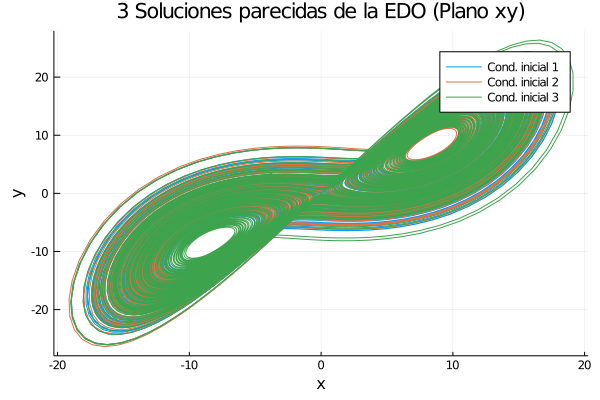

In [48]:
plot(title="3 Soluciones parecidas de la EDO (Plano xy)",xlabel="x",ylabel="y")
tiempo = collect(0:0.01:50π)
solnum_rk4_1 = RK_4(edo_xyz,cond_inic_1,tiempo)
solnum_rk4_2 = RK_4(edo_xyz,cond_inic_2,tiempo)
solnum_rk4_3 = RK_4(edo_xyz,cond_inic_3,tiempo)
plot!(solnum_rk4_1[:,1],solnum_rk4_1[:,2], label="Cond. inicial 1")
plot!(solnum_rk4_2[:,1],solnum_rk4_2[:,2], label="Cond. inicial 2")
plot!(solnum_rk4_3[:,1],solnum_rk4_3[:,2], label="Cond. inicial 3")
plot!(legend=true, grid=true)

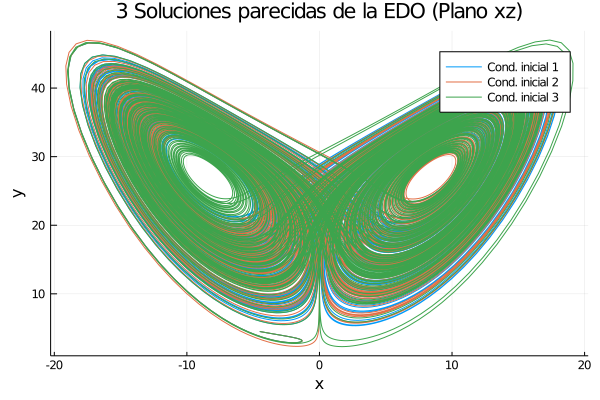

In [49]:
plot(title="3 Soluciones parecidas de la EDO (Plano xz)",xlabel="x",ylabel="y")
tiempo = collect(0:0.01:50π)
solnum_rk4_1 = RK_4(edo_xyz,cond_inic_1,tiempo)
solnum_rk4_2 = RK_4(edo_xyz,cond_inic_2,tiempo)
solnum_rk4_3 = RK_4(edo_xyz,cond_inic_3,tiempo)
plot!(solnum_rk4_1[:,1],solnum_rk4_1[:,3], label="Cond. inicial 1")
plot!(solnum_rk4_2[:,1],solnum_rk4_2[:,3], label="Cond. inicial 2")
plot!(solnum_rk4_3[:,1],solnum_rk4_3[:,3], label="Cond. inicial 3")
plot!(legend=true, grid=true)

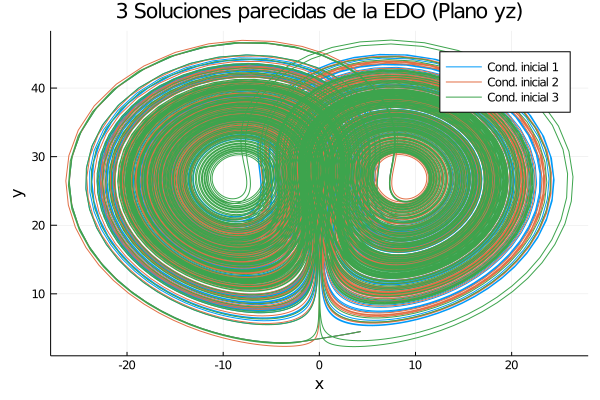

In [50]:
plot(title="3 Soluciones parecidas de la EDO (Plano yz)",xlabel="x",ylabel="y")
tiempo = collect(0:0.01:50π)
solnum_rk4_1 = RK_4(edo_xyz,cond_inic_1,tiempo)
solnum_rk4_2 = RK_4(edo_xyz,cond_inic_2,tiempo)
solnum_rk4_3 = RK_4(edo_xyz,cond_inic_3,tiempo)
plot!(solnum_rk4_1[:,2],solnum_rk4_1[:,3], label="Cond. inicial 1")
plot!(solnum_rk4_2[:,2],solnum_rk4_2[:,3], label="Cond. inicial 2")
plot!(solnum_rk4_3[:,2],solnum_rk4_3[:,3], label="Cond. inicial 3")
plot!(legend=true, grid=true)

Observando las gráficas anteriores, podemos notar que todas las soluciones tienen la misma forma sin importar la condición inicial, sin embargo si se puede apreciar un ligero desfase entre ellas (ya que se pueden distinguir los 3 colores), por lo que no podemos decir que son iguales, lo cual tiene sentido ya que las soluciones dependen justo de las condiciones iniciales que se tengan.

Finalmente, vamos a comprobar que para cada una de las soluciones tengamos al menos 5 cifras significativas:

In [51]:
solnum_rk4_1 = RK_4(edo_xyz,cond_inic_1,tiempo)

15708×3 Array{Float64,2}:
 -4.50125   4.31199    4.5062 
 -3.7123    3.30665    4.23378
 -3.08577   2.46906    4.02584
 -2.59183   1.76715    3.86077
 -2.20629   1.17351    3.72448
 -1.90968   0.665029   3.60787
 -1.6864    0.222334   3.50509
 -1.524    -0.170815   3.41245
 -1.41266  -0.528084   3.32771
 -1.34466  -0.861065   3.24958
 -1.31407  -1.1797     3.17743
 -1.31639  -1.49266    3.11114
 -1.34831  -1.80763    3.05094
  ⋮                           
 -3.29774  -4.60389   17.3584 
 -3.43713  -4.91961   17.0598 
 -3.59439  -5.25811   16.7874 
 -3.77007  -5.62105   16.5432 
 -3.96482  -6.01008   16.3298 
 -4.17939  -6.42676   16.1499 
 -4.41458  -6.87251   16.0068 
 -4.67127  -7.34856   15.9043 
 -4.95034  -7.85582   15.8467 
 -5.25266  -8.39479   15.8386 
 -5.57903  -8.96538   15.8857 
 -5.93014  -9.56679   15.9939 

In [52]:
solnum_rk4_2 = RK_4(edo_xyz,cond_inic_2,tiempo)

15708×3 Array{Float64,2}:
 -4.50125   4.32199      4.5062 
 -3.71135   3.31665      4.23339
 -3.08395   2.47928      4.02516
 -2.58919   1.77778      3.85986
 -2.20286   1.18474      3.72339
 -1.90548   0.677049     3.60661
 -1.6814    0.23533      3.50366
 -1.51819  -0.156654     3.41085
 -1.40599  -0.51256      3.32591
 -1.33708  -0.843969     3.24756
 -1.3055   -1.16081      3.17515
 -1.30673  -1.47174      3.10854
 -1.33748  -1.78441      3.04796
  ⋮                             
  4.91118   0.0283936   29.327  
  4.44407  -0.0158525   28.5554 
  4.01903  -0.0234022   27.8031 
  3.63517  -0.00189375  27.0709 
  3.29103   0.0422359   26.3591 
  2.98471   0.103672    25.6677 
  2.71405   0.178115    24.9962 
  2.47671   0.26217     24.3441 
  2.27031   0.353222    23.7106 
  2.09248   0.449333    23.0953 
  1.9409    0.549134    22.4975 
  1.81339   0.651733    21.9166 

In [53]:
solnum_rk4_3 = RK_4(edo_xyz,cond_inic_3,tiempo)

15708×3 Array{Float64,2}:
 -4.50125    4.30199    4.5062 
 -3.71325    3.29664    4.23416
 -3.08759    2.45884    4.02651
 -2.59447    1.75652    3.86167
 -2.20972    1.16228    3.72557
 -1.91389    0.653009   3.60913
 -1.69139    0.209339   3.50652
 -1.52981   -0.184975   3.41406
 -1.41933   -0.543607   3.32952
 -1.35225   -0.878159   3.25161
 -1.32265   -1.19859    3.17973
 -1.32604   -1.51358    3.11375
 -1.35915   -1.83084    3.05394
  ⋮                            
 -0.422993  -0.811418  13.7184 
 -0.462596  -0.867053  13.3611 
 -0.504058  -0.929655  13.0138 
 -0.547888  -0.999706  12.6763 
 -0.594595  -1.07777   12.3486 
 -0.6447    -1.1645    12.0305 
 -0.698739  -1.26065   11.722  
 -0.757275  -1.36706   11.423  
 -0.820902  -1.48471   11.1335 
 -0.890255  -1.61466   10.8536 
 -0.966018  -1.75812   10.5834 
 -1.04893   -1.91645   10.3232 

Efectivamente, para los 3 casos tenemos una solución con al menos 5 cifras significativas.